In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


/home/junshern/Scripts/fyp-virtualenv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

In [3]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [4]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 39s 646us/step - loss: 0.2156 - val_loss: 0.1663
Epoch 2/50
60000/60000 [==============================] - 29s 477us/step - loss: 0.1524 - val_loss: 0.1417
Epoch 3/50
 6528/60000 [==>...........................] - ETA: 25s - loss: 0.1424

In [17]:
import pypianoroll

multi = pypianoroll.parse('/tmp/record_midi.mid')
for track in multi.tracks:
    printInfo(track)

IndexError: index -2 is out of bounds for axis 0 with size 1

(128, 6)


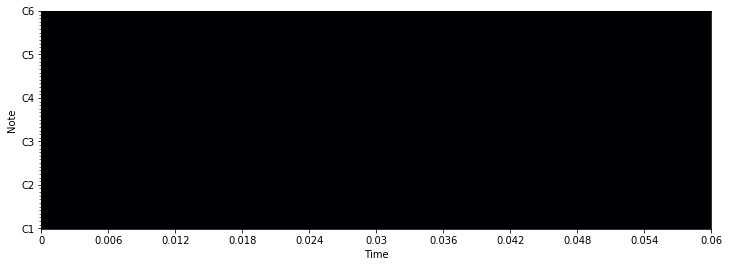

In [20]:
import pretty_midi
import numpy as np
# For plotting
# import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))


pm = pretty_midi.PrettyMIDI('/tmp/record_midi.mid')
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)
proll = pm.get_piano_roll()
print(proll.shape)

0

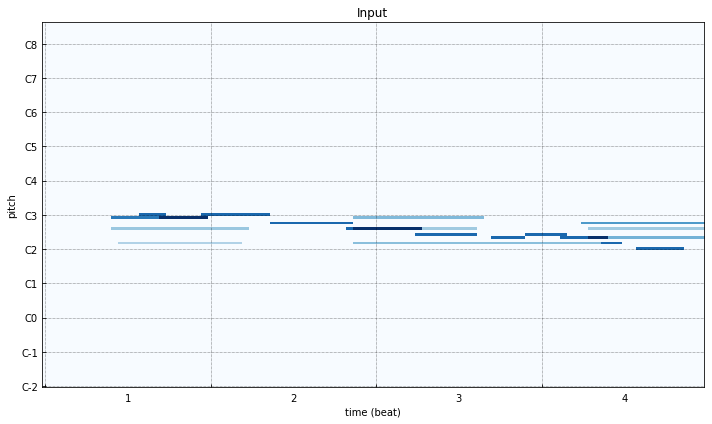

In [10]:
import numpy as np
import pianoroll_utils
from matplotlib import pyplot as plt
import pypianoroll

input_pianoroll = np.load('recorded_pianoroll.npy').swapaxes(0,1).reshape(96, 128)
comp_pianoroll = np.load('generated_pianoroll.npy').swapaxes(0,1).reshape(96, 128)
test = input_pianoroll + comp_pianoroll
# Plot comparison
fig, ax = plt.subplots()
fig.set_size_inches(10, 6, forward=True)
ax.set_title('Input')
pypianoroll.plot_pianoroll(ax, test, beat_resolution=24)
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(test)
